# Association rules using Instacart Market Basket Analysis Dataset

### Motivation:
Understand consumer behaviour using a machine learning algorithm. 

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instacart-market-basket-analysis/order_products__train.csv.zip
/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv.zip
/kaggle/input/instacart-market-basket-analysis/sample_submission.csv.zip
/kaggle/input/instacart-market-basket-analysis/aisles.csv.zip
/kaggle/input/instacart-market-basket-analysis/orders.csv.zip
/kaggle/input/instacart-market-basket-analysis/products.csv.zip
/kaggle/input/instacart-market-basket-analysis/departments.csv.zip


In [6]:
!pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=ccc986ab7d42ff5366a91b5fe092e90a9f0dafda3573d416f2b1eb24734f00a0
  Stored in directory: /root/.cache/pip/wheels/cb/f6/e1/57973c631d27efd1a2f375bd6a83b2a616c4021f24aab84080
Successfully built apyori


In [21]:
from apyori import apriori
from collections import Counter
from datetime import datetime
from itertools import combinations
import matplotlib.pyplot as plt

> ### Preparing the data

In [106]:
import zipfile
with zipfile.ZipFile('../input/instacart-market-basket-analysis/aisles.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('output')
with zipfile.ZipFile('../input/instacart-market-basket-analysis/departments.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('output')    
with zipfile.ZipFile('../input/instacart-market-basket-analysis/orders.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('output')
with zipfile.ZipFile('../input/instacart-market-basket-analysis/order_products__prior.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('output')
with zipfile.ZipFile('../input/instacart-market-basket-analysis/order_products__train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('output')
with zipfile.ZipFile('../input/instacart-market-basket-analysis/products.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('output')

Checking if the files are in the folder 'output'

In [107]:
from subprocess import check_output
print(check_output(["ls", "./output"]).decode("utf8"))

__MACOSX
aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv



### Reading the datasets
Checking data types and other information about the Aisles, Departments, Products and Orders Datasets. 

The dataset aisles contains all the ailes in the supermarket. To each aisle it is assigned an ID. 

In [60]:
aisles = pd.read_csv('./output/aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [144]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [44]:
aisles.isna().sum(axis = 0)

aisle_id    0
aisle       0
dtype: int64

The dataset departments contains a list of all departments in the supermarket. To each department it is assigned an ID. 

In [61]:
departments = pd.read_csv('./output/departments.csv')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [145]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [63]:
departments.shape

(21, 2)

There are 21 departments in this supermarket

The dataset Products lists all the products there are in the supermarket classified by aisle ID and department ID

In [64]:
products = pd.read_csv('./output/products.csv') 
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [146]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [67]:
products.shape

(49688, 4)

In [70]:
products.isna().sum(axis = 0)

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

The dataset orders tells to which set (prior, train, test) an order belongs, considering the machine learning model. 

In [118]:
orders = pd.read_csv('./output/orders.csv') 
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [147]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [72]:
orders.shape

(3421083, 7)

Let's check how many data points are associated to each label of the eval_set column:

In [74]:
orders.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

Deleting unecessary data for this analysis:

In [76]:
orders.drop('eval_set', axis = 1, inplace=True)

Checking for missing values

In [77]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.008665e+06
mean,1.710827e+06,1.029701e+05,1.719107e+01,2.776364e+00,1.344347e+01,1.070724e+01
std,9.875206e+05,5.953411e+04,1.779950e+01,2.041806e+00,4.226246e+00,8.954180e+00
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.556832e+05,5.138500e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.711120e+06,1.026620e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.566034e+06,1.543720e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01


In [79]:
orders.isna().sum(axis = 0)

order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [80]:
orders.loc[orders.days_since_prior_order.isna()]

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
11,2168274,2,1,2,11,NaN
26,1374495,3,1,1,14,NaN
39,3343014,4,1,6,11,NaN
45,2717275,5,1,3,12,NaN
...,...,...,...,...,...,...
3420930,969311,206205,1,4,12,NaN
3420934,3189322,206206,1,3,18,NaN
3421002,2166133,206207,1,6,19,NaN
3421019,2227043,206208,1,1,15,NaN


The column days_since_prior_order has NaN values becuase the first order (order_number = 1) obviously has no information on days since prior order, since this is the first order. 

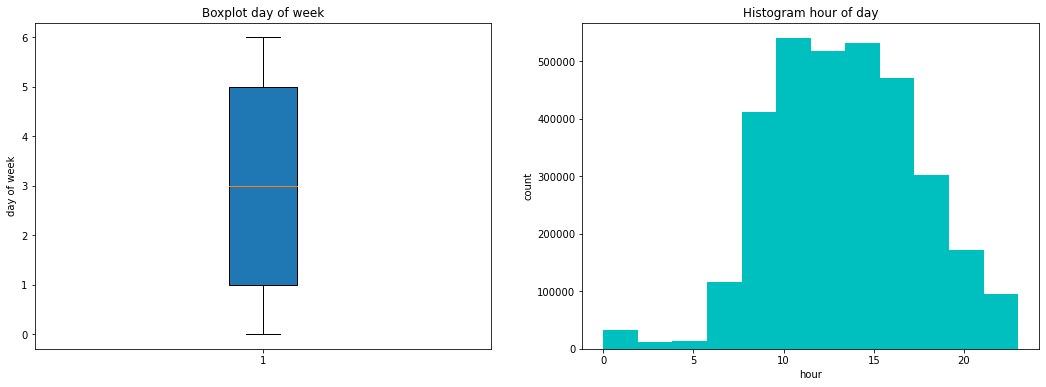

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].boxplot(orders.order_dow, patch_artist=True)
ax[0].set_title('Boxplot day of week')
ax[0].set_ylabel('day of week')
n_bins=12
ax[1].hist(orders.order_hour_of_day, color='c', bins=n_bins)
ax[1].set_title('Histogram hour of day')
ax[1].set_xlabel('hour')
ax[1].set_ylabel('count');

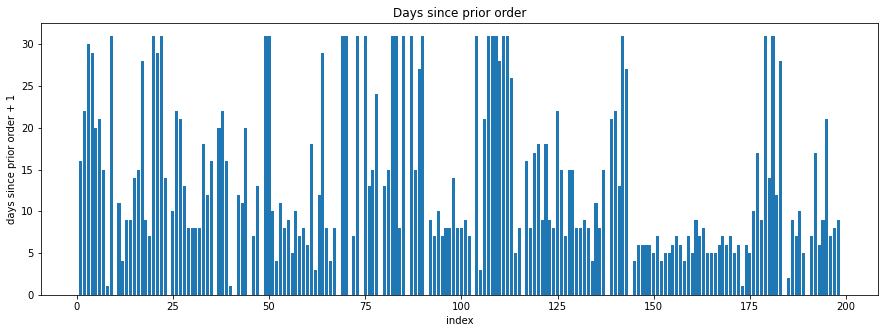

In [99]:
plt.figure(figsize = (15,5))
plt.bar(range(200), orders.days_since_prior_order[:200] + 1)
plt.title('Days since prior order')
plt.xlabel('index')
plt.ylabel('days since prior order + 1');

In [109]:
orders_prior = pd.read_csv('./output/order_products__prior.csv') 
orders_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


This dataframe has an important information: the 'reordered' column informs us how many times a client ordered again a product.

In [148]:
orders_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [112]:
orders_prior.shape

(32434489, 4)

In [114]:
orders_prior.isna().sum(axis=0)

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

There are no NaN values in this dataframe so we do not need to treat the data. 

### Creating a new dataframe for the study

In [120]:
orders_apriori = orders.copy()
orders_apriori.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [122]:
#Visualizing number of orders by user id:
orders_by_user = orders.groupby('user_id')['order_number'].max()

In [123]:
orders_by_user.head()

user_id
1    11
2    15
3    13
4     6
5     5
Name: order_number, dtype: int64

In [128]:
orders_prior.head(15)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


Now we will merge 2 dataframes: orders (only the information order_id and user_id and orders_prior order_id and add_to_cart_order(renamed to size_of_order)

In [134]:
products_by_user = orders[['order_id', 'user_id']].merge(
    orders_prior[['order_id', 'add_to_cart_order']].groupby('order_id').max().rename({'add_to_cart_order': 'size_of_order'}, axis = 1),
                                                                                        on = 'order_id')

In [135]:
products_by_user.head()

,order_id,user_id,size_of_order
0,2539329,1,5
1,2398795,1,6
2,473747,1,5
3,2254736,1,5
4,431534,1,8


In [139]:
products_by_user = products_by_user.drop('order_id', axis = 1).groupby('user_id')['size_of_order'].sum()

In [143]:
#Checking max and minimum orders by user: 
min_ord= min(orders_by_user)
max_ord= max(orders_by_user)
print("The maximum orders by user is {} and the minimum orders by user is {} " .format(max_ord, min_ord))


The maximum orders by user is 100 and the minimum orders by user is 4 
